In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1,)# (1,1,1,0)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
res_ds_regr = pd.read_csv('evaluation_regr_full_10est6depth.csv', index_col=0)
print(res_ds_regr.shape)
res_ds_regr.head()

(60, 40)


,ensemble_model,ds,fold_id,train_size,test_size,ensemble_time,dl_time,param_random_state,param_max_depth,ensemble_metric_mse_train,...,dl_ens_metric_mse_test,dl_ens_metric_mae_train,dl_ens_metric_mae_test,dl_ens_metric_r2_train,dl_ens_metric_r2_test,dl_ens_metric_wape_train,dl_ens_metric_wape_test,dl_ens_metric_rmse_perc_train,dl_ens_metric_rmse_perc_test,param_n_estimators
0,DecisionTreeRegressor,calhouse,0,16512,4128,0.082303,24.763710,42.0,10,0.212676,...,3.846784e-32,3.769662e-17,8.775818e-17,1.000000,1.000000,2.122713e-15,6.128040e-15,6.091424e-17,9.466045e-17,NaN
1,RandomForestRegressor,calhouse,0,16512,4128,0.335189,192.211092,42.0,6,0.378743,...,2.318476e-04,7.139513e-05,6.127589e-04,0.999981,0.999738,2.056186e-03,2.682180e-02,1.866719e-03,7.133605e-03,10.0
2,GradientBoostingRegressor,calhouse,0,16512,4128,0.612959,202.950308,42.0,6,0.470788,...,2.560276e-06,4.480259e-05,3.260051e-05,0.999991,0.999994,1.679268e-03,1.040422e-03,8.305722e-04,7.518853e-04,10.0
3,XGBRegressor,calhouse,0,16512,4128,0.155434,217.985954,NaN,6,0.235520,...,2.207099e-04,1.290471e-07,8.430298e-04,1.000000,0.999786,6.103255e-06,3.921876e-02,8.526724e-08,7.219035e-03,10.0
4,DecisionTreeRegressor,calhouse,1,16512,4128,0.103057,30.378534,42.0,10,0.199525,...,9.261857e-32,1.330778e-16,2.353576e-16,1.000000,1.000000,7.621675e-15,1.173202e-14,1.168232e-16,1.369255e-16,NaN


# Compare the time to construct a lattice

## Classification results as latex tables

In [5]:
def prepare_result_table_tolatex(res_ds, models_order, ds_type, metric, ascending=False):
    train_pivot_ds = res_ds.pivot_table(index='model',columns='ds', values=f'{metric}_{ds_type}')
    train_pivot_ds = train_pivot_ds.loc[models_order]
    train_pivot_ds = train_pivot_ds.T

    train_pivot_ds = train_pivot_ds.round(2)
    train_pivot_ds_rank = train_pivot_ds.rank(1, ascending=not ascending)
    train_pivot_ds.loc['mean rank'] = train_pivot_ds_rank.mean(0)
    train_pivot_ds = train_pivot_ds.round(2)
    
    return train_pivot_ds

In [6]:
def combine_train_test_tables(res_ds, models_order, metric, ascending=False):
    cdss = []
    for ds_type in ['train', 'test']:
        cds = prepare_result_table_tolatex(res_ds, models_order, ds_type, metric, ascending=ascending).T
        columns_order = cds.columns
        cds.columns = pd.MultiIndex.from_tuples([(f, ds_type) for f in cds.columns])
        cdss.append(cds)
    cds = pd.concat(cdss, 1)
    cds = cds[[(f, ds_type) for f in columns_order for ds_type in ['train', 'test']]]
    return cds

In [7]:
def prepare_result_table_tolatex_diff(res_ds, models_order, ds_type, metric, ascending=False):
    train_pivot_ds = res_ds.pivot_table(index='model',columns='ds', values=f'{metric}_{ds_type}')
    train_pivot_ds = train_pivot_ds.loc[models_order]
    train_pivot_ds = train_pivot_ds
    train_pivot_ds.loc['best'] = train_pivot_ds.max() if ascending else train_pivot_ds.min()
    train_pivot_ds.iloc[:-1] = (train_pivot_ds.iloc[:-1]-train_pivot_ds.loc['best'])
    train_pivot_ds['mean diff'] = train_pivot_ds.mean(1)
    
    #train_pivot_ds['mean diff rank'] = train_pivot_ds.drop('best')['mean diff'].rank(ascending=ascending)
    train_pivot_ds = train_pivot_ds.round(2)
    
    train_pivot_ds = train_pivot_ds.T
    
    return train_pivot_ds

In [8]:
def combine_train_test_tables_diff(res_ds, models_order, metric, ascending=False):
    cdss = []
    for ds_type in ['train', 'test']:
        cds = prepare_result_table_tolatex_diff(res_ds, models_order, ds_type, metric, ascending=ascending).T
        columns_order = cds.columns
        cds.columns = pd.MultiIndex.from_tuples([(f, ds_type) for f in cds.columns])
        cdss.append(cds)
    #return cdss
    cds = pd.concat(cdss, 1)
    cds = cds[[(f, ds_type) for f in columns_order for ds_type in ['train', 'test']]]
    return cds

In [9]:
m = 'dl_ens_metric_rmse_perc'
res_ds_regr.groupby(['ensemble_model','ds',])[[f'{m}_train',f'{m}_test']].mean()

dl_ens_metric_rmse_perc_train  \
ensemble_model            ds                                        
DecisionTreeRegressor     boston                     6.914072e-17   
                          calhouse                   8.645658e-17   
                          diabetes                   5.423118e-17   
GradientBoostingRegressor boston                     1.935376e-02   
                          calhouse                   3.696858e-04   
                          diabetes                   1.337642e-02   
RandomForestRegressor     boston                     2.087198e-02   
                          calhouse                   2.524146e-02   
                          diabetes                   6.461190e-03   
XGBRegressor              boston                     7.460909e-08   
                          calhouse                   7.831150e-08   
                          diabetes                   6.993364e-08   

                                    dl_ens_metric_rmse_perc_test  
ensemble_model            ds                                      
DecisionTreeRegressor     boston                        0.001623  
                          calhouse                      0.004013  
                          diabetes                      0.019586  
GradientBoostingRegressor boston                        0.019103  
                          calhouse                      0.000661  
                          diabetes                      0.008242  
RandomForestRegressor     boston                        0.010529  
                          calhouse                      0.028463  
                          diabetes                      0.010808  
XGBRegressor              boston                        0.010342  
                          calhouse                      0.005536  
                          diabetes                      0.025483

In [10]:
m = 'dl_ens_metric_wape'
res_ds_regr.groupby(['ensemble_model','ds',])[[f'{m}_train',f'{m}_test']].mean()

dl_ens_metric_wape_train  \
ensemble_model            ds                                   
DecisionTreeRegressor     boston                4.284806e-15   
                          calhouse              4.467607e-15   
                          diabetes              4.021180e-15   
GradientBoostingRegressor boston                4.364869e-01   
                          calhouse              7.084425e-04   
                          diabetes              3.518358e-01   
RandomForestRegressor     boston                8.783892e-01   
                          calhouse              1.754644e+00   
                          diabetes              9.508573e-02   
XGBRegressor              boston                5.512942e-06   
                          calhouse              5.666576e-06   
                          diabetes              5.463701e-06   

                                    dl_ens_metric_wape_test  
ensemble_model            ds                                 
DecisionTreeRegressor     boston                   0.020140  
                          calhouse                 0.007848  
                          diabetes                 0.247190  
GradientBoostingRegressor boston                   0.625278  
                          calhouse                 0.001707  
                          diabetes                 0.307363  
RandomForestRegressor     boston                   0.838081  
                          calhouse                 1.883673  
                          diabetes                 0.304056  
XGBRegressor              boston                   0.218168  
                          calhouse                 0.032670  
                          diabetes                 0.590498

In [11]:
m = 'dl_metric_wape'
cds = res_ds_regr.groupby(['ensemble_model','ds',])[[f'{m.replace("dl","ensemble")}_train', f'{m}_train',
                                                     f'{m.replace("dl","ensemble")}_test', f'{m}_test']].mean()
cds['diff_train'] = cds['ensemble_metric_wape_train']-cds['dl_metric_wape_train']
cds['diff_test'] = cds['ensemble_metric_wape_test']-cds['dl_metric_wape_test']
cds = cds[['ensemble_metric_wape_train', 'dl_metric_wape_train','diff_train',
          'ensemble_metric_wape_test', 'dl_metric_wape_test', 'diff_test']]
cds = cds.round(2)
cds = cds.rename(
    columns={
        f: f.replace('_metric','').replace('_wape','').replace('ensemble','base model').replace('diff_', '$\Delta$_')
        for f in cds.columns
    }
)

cds.index.names = [f.replace('ensemble_','Base ').replace('ds','Dataset') for f in cds.index.names]
print('WAPE')
cds.columns = pd.MultiIndex.from_tuples([
    tuple([
        x.capitalize() if x!='$\Delta$' else x
        for x in f.split('_')[::-1]]) for f in cds.columns
])
cds

WAPE


Train                       Test  \
                                   Base model     Dl $\Delta$ Base model   
Base model                Dataset                                          
DecisionTreeRegressor     boston         2.37   2.37    -0.00      19.41   
                          calhouse      17.66  17.66     0.00      31.86   
                          diabetes       5.68   5.68     0.00      52.83   
GradientBoostingRegressor boston        14.73  14.96    -0.22      21.87   
                          calhouse      34.31  34.31    -0.00      39.48   
                          diabetes      32.54  32.74    -0.20      47.59   
RandomForestRegressor     boston         7.87   8.21    -0.34      16.06   
                          calhouse      26.23  26.89    -0.67      33.80   
                          diabetes      27.64  27.63     0.01      41.45   
XGBRegressor              boston         5.51   5.51     0.00      14.69   
                          calhouse      18.28  18.28     0.00      27.37   
                          diabetes      13.25  13.25    -0.00      39.82   

                                                    
                                       Dl $\Delta$  
Base model                Dataset                   
DecisionTreeRegressor     boston    19.43    -0.02  
                          calhouse  31.86    -0.00  
                          diabetes  52.67     0.16  
GradientBoostingRegressor boston    21.91    -0.04  
                          calhouse  39.48     0.00  
                          diabetes  47.62    -0.03  
RandomForestRegressor     boston    16.53    -0.47  
                          calhouse  34.28    -0.48  
                          diabetes  41.43     0.02  
XGBRegressor              boston    14.78    -0.09  
                          calhouse  27.36     0.01  
                          diabetes  39.77     0.05

In [12]:
print(cds.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
             &          & \multicolumn{3}{l}{Train} & \multicolumn{3}{l}{Test} \\
             &          & Base model &     Dl & \$\textbackslash Delta\$ & Base model &     Dl & \$\textbackslash Delta\$ \\
Base model & Dataset &            &        &          &            &        &          \\
\midrule
DecisionTreeRegressor & boston &       2.37 &   2.37 &    -0.00 &      19.41 &  19.43 &    -0.02 \\
             & calhouse &      17.66 &  17.66 &     0.00 &      31.86 &  31.86 &    -0.00 \\
             & diabetes &       5.68 &   5.68 &     0.00 &      52.83 &  52.67 &     0.16 \\
GradientBoostingRegressor & boston &      14.73 &  14.96 &    -0.22 &      21.87 &  21.91 &    -0.04 \\
             & calhouse &      34.31 &  34.31 &    -0.00 &      39.48 &  39.48 &     0.00 \\
             & diabetes &      32.54 &  32.74 &    -0.20 &      47.59 &  47.62 &    -0.03 \\
RandomForestRegressor & boston &       7.87 &   8.21 &    -0.34 &      16.06 &  16.

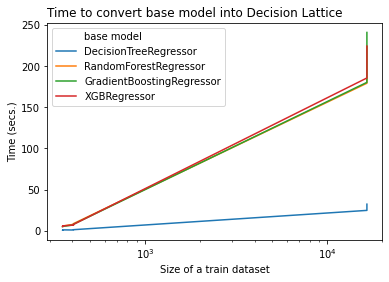

In [13]:
# time to construct a model from a base model
cds = res_ds_regr.copy()
cds = cds.rename(columns={'train_size': 'size of a train dataset', 'ensemble_model': 'base model', 'dl_time':'time (secs.)'})
sns.lineplot(x='size of a train dataset', y='time (secs.)', hue='base model', data=cds, estimator=None)
plt.xlabel('Size of a train dataset')
plt.ylabel("Time (secs.)")
plt.xscale('log')
plt.title('Time to convert base model into Decision Lattice', loc='left')
plt.show()

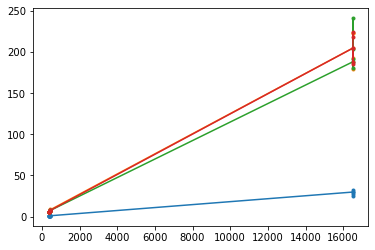

In [14]:
# time to construct a model from a base model
cds = res_ds_regr.copy()
#cds = cds.rename(columns={'train_size': 'size of a train dataset', 'ensemble_model': 'base model', 'dl_time':'time (secs.)'})
#sns.lineplot(x='size of a train dataset', y='time (secs.)', hue='base model', data=cds,)
for bm in cds['ensemble_model'].unique():
    cds_ = cds[cds['ensemble_model']==bm]
    plt.plot(cds_['train_size'], cds_['dl_time'], '.-')